In [8]:
a = 'hello'
a.__hash__()
hash(a)

2231539624840386101

In [9]:
a = [1, 2, 3]
hash(a)

TypeError: unhashable type: 'list'

In [10]:
a = 'hello'
a[0] = 'H'

TypeError: 'str' object does not support item assignment

In [13]:
b = ([1, 2, 3], 2, 3)
hash(b)

TypeError: unhashable type: 'list'

In [29]:
import time
import matplotlib.pyplot as plt
import numpy as np

class SimpleHashTable:
    """
    Простая хэш-таблица без разрешения коллизий.
    При коллизии новые данные перезаписывают старые.
    """
    
    def __init__(self, size=100):
        self.size = size
        self.table = [None] * size
        self.collisions = 0
        self.overwrites = 0
    
    def _hash(self, key):
        """Простая хэш-функция для строк и чисел"""
        if isinstance(key, int):
            return key % self.size
        # elif isinstance(key, str):
        #     return sum(ord(c) for c in key) % self.size
        else:
            return hash(key) % self.size
    
    def insert(self, key, value):
        """Вставка элемента (при коллизии перезаписывает)"""
        index = self._hash(key)
        
        if self.table[index] is not None:
            # Коллизия - перезаписываем существующее значение
            self.collisions += 1
            self.overwrites += 1
        
        self.table[index] = (key, value)
    
    def search(self, key):
        """Поиск элемента по ключу"""
        index = self._hash(key)
        
        if self.table[index] is not None and self.table[index][0] == key:
            return self.table[index][1]
        return None
    
    def get_stats(self):
        """Статистика таблицы"""
        occupied = sum(1 for item in self.table if item is not None)
        return {
            'size': self.size,
            'occupied': occupied,
            'load_factor': occupied / self.size,
            'collisions': self.collisions,
            'overwrites': self.overwrites,
            'data_loss': self.overwrites
        }

In [30]:
class ChainedHashTable:
    """
    Хэш-таблица с разрешением коллизий методом цепочек.
    Каждая ячейка содержит список пар (key, value).
    """
    
    def __init__(self, size=100):
        self.size = size
        self.table = [[] for _ in range(size)]
        self.collisions = 0
        self.total_items = 0
    
    def _hash(self, key):
        """Хэш-функция"""
        if isinstance(key, int):
            return key % self.size
        # elif isinstance(key, str):
        #     return sum(ord(c) for c in key) % self.size
        else:
            return hash(key) % self.size
    
    def insert(self, key, value):
        """Вставка элемента в цепочку"""
        index = self._hash(key)
        bucket = self.table[index]
        
        # Проверяем, есть ли уже такой ключ в цепочке
        for i, (k, v) in enumerate(bucket):
            if k == key:
                bucket[i] = (key, value)  # Обновляем значение
                return
        
        # Если ключа нет, добавляем новую пару
        if len(bucket) > 0:
            self.collisions += 1  # Коллизия, если в цепочке уже есть элементы
        
        bucket.append((key, value))
        self.total_items += 1
    
    def search(self, key):
        """Поиск элемента в цепочке"""
        index = self._hash(key)
        bucket = self.table[index]
        
        for k, v in bucket:
            if k == key:
                return v
        return None
    
    def get_stats(self):
        """Статистика таблицы"""
        non_empty_buckets = sum(1 for bucket in self.table if len(bucket) > 0)
        max_chain_length = max(len(bucket) for bucket in self.table)
        avg_chain_length = self.total_items / non_empty_buckets if non_empty_buckets > 0 else 0
        
        return {
            'size': self.size,
            'total_items': self.total_items,
            'non_empty_buckets': non_empty_buckets,
            'load_factor': non_empty_buckets / self.size,
            'collisions': self.collisions,
            'max_chain_length': max_chain_length,
            'avg_chain_length': avg_chain_length,
            'memory_usage': self._estimate_memory()
        }
    
    def _estimate_memory(self):
        """Оценка использования памяти"""
        # Базовый размер таблицы + размер всех цепочек
        base_memory = self.size * 8  # 8 байт на указатель списка
        chain_memory = sum(len(bucket) * 16 for bucket in self.table)  # 16 байт на элемент
        return base_memory + chain_memory

In [31]:
import this

In [32]:
class OpenAddressingHashTable:
    """
    Хэш-таблица с разрешением коллизий методом открытой адресации.
    Использует линейное пробирование.
    """
    
    def __init__(self, size=100):
        self.size = size
        self.table = [None] * size
        self.collisions = 0
        self.total_items = 0
        self.DELETED = object()  # Маркер удаленного элемента
    
    def _hash(self, key):
        """Основная хэш-функция"""
        if isinstance(key, int):
            return key % self.size
        # elif isinstance(key, str):
        #     return sum(ord(c) for c in key) % self.size
        else:
            return hash(key) % self.size
    
    def _probe(self, key, i):
        """Функция пробирования (линейная)"""
        return (self._hash(key) + i) % self.size
    
    def insert(self, key, value):
        """Вставка элемента с пробированием"""
        for i in range(self.size):
            index = self._probe(key, i)
            
            if self.table[index] is None or self.table[index] is self.DELETED:
                # Нашли свободную ячейку
                if i > 0:
                    self.collisions += i  # Учитываем все шаги пробирования
                self.table[index] = (key, value)
                self.total_items += 1
                return
            
            elif self.table[index][0] == key:
                # Обновляем существующий ключ
                self.table[index] = (key, value)
                return
        
        raise Exception("Хэш-таблица переполнена")
    
    def search(self, key):
        """Поиск элемента с пробированием"""
        for i in range(self.size):
            index = self._probe(key, i)
            
            if self.table[index] is None:
                # Достигли пустой ячейки - ключ не найден
                return None
            elif self.table[index] is self.DELETED:
                # Пропускаем удаленные ячейки
                continue
            elif self.table[index][0] == key:
                # Нашли ключ
                return self.table[index][1]
        
        return None
    
    def delete(self, key):
        """Удаление элемента (помечаем как DELETED)"""
        for i in range(self.size):
            index = self._probe(key, i)
            
            if self.table[index] is None:
                return False
            elif self.table[index] is self.DELETED:
                continue
            elif self.table[index][0] == key:
                self.table[index] = self.DELETED
                self.total_items -= 1
                return True
        
        return False
    
    def get_stats(self):
        """Статистика таблицы"""
        occupied = sum(1 for item in self.table if item is not None and item is not self.DELETED)
        
        # Считаем среднюю длину пробирования
        probe_lengths = []
        for item in self.table:
            if item is not None and item is not self.DELETED:
                key = item[0]
                for i in range(self.size):
                    if self._probe(key, i) == self.table.index(item):
                        probe_lengths.append(i)
                        break
        
        avg_probe_length = sum(probe_lengths) / len(probe_lengths) if probe_lengths else 0
        
        return {
            'size': self.size,
            'occupied': occupied,
            'load_factor': occupied / self.size,
            'collisions': self.collisions,
            'avg_probe_length': avg_probe_length,
            'memory_usage': self._estimate_memory()
        }
    
    def _estimate_memory(self):
        """Оценка использования памяти"""
        # Каждая ячейка хранит tuple (key, value) + служебная информация
        return self.size * 24  # Примерная оценка

In [33]:
def performance_test():
    """Тестирование производительности всех трех реализаций"""
    
    # Тестовые данные
    test_size = 1000
    test_keys = [f"key_{i}" for i in range(test_size)]
    test_values = [f"value_{i}" for i in range(test_size)]
    
    implementations = {
        "Simple (no collision resolution)": SimpleHashTable(1500),
        "Chained hashing": ChainedHashTable(1000),
        "Open addressing": OpenAddressingHashTable(1500)
    }
    
    results = {}
    
    for name, hash_table in implementations.items():
        print(f"\n=== Testing {name} ===")
        
        # Тест вставки
        start_time = time.time()
        for key, value in zip(test_keys, test_values):
            hash_table.insert(key, value)
        insert_time = time.time() - start_time
        
        # Тест поиска
        start_time = time.time()
        for key in test_keys[:500]:  # Ищем только половину ключей
            hash_table.search(key)
        search_time = time.time() - start_time
        
        # Получаем статистику
        stats = hash_table.get_stats()
        stats['insert_time'] = insert_time
        stats['search_time'] = search_time
        
        results[name] = stats
        
        print(f"Insert time: {insert_time:.4f}s")
        print(f"Search time: {search_time:.4f}s")
        print(f"Load factor: {stats['load_factor']:.3f}")
        
        if 'occupied' in stats:
            print(f"Occupied: {stats['occupied']}")
        if 'non_empty_buckets' in stats:
            print(f"Non empty buckets: {stats['non_empty_buckets']}")
        if 'collisions' in stats:
            print(f"Collisions: {stats['collisions']}")
        if 'overwrites' in stats:
            print(f"Data loss (overwrites): {stats['overwrites']}")
        if 'avg_chain_length' in stats:
            print(f"Average chain length: {stats['avg_chain_length']:.2f}")
        if 'avg_probe_length' in stats:
            print(f"Average probe length: {stats['avg_probe_length']:.2f}")
        if 'memory_usage' in stats:
            print(f"Memory usage: {stats['memory_usage']} bytes")
    
    return results

def analyze_complexity():
    """Анализ временной сложности"""
    sizes = [100, 500, 1000, 2000]
    
    for size in sizes:
        print(f"\n--- Testing with {size} elements ---")
        
        # Создаем таблицы с разным коэффициентом загрузки
        chained = ChainedHashTable(size)
        open_addr = OpenAddressingHashTable(int(size * 1.5))
        
        # Вставляем элементы
        for i in range(size):
            key = f"key_{i}"
            chained.insert(key, f"value_{i}")
            open_addr.insert(key, f"value_{i}")
        
        # Анализируем производительность
        chained_stats = chained.get_stats()
        open_stats = open_addr.get_stats()
        
        print(f"Chained - Load factor: {chained_stats['load_factor']:.2f}, "
              f"Avg chain: {chained_stats.get('avg_chain_length', 0):.2f}")
        print(f"Open addressing - Load factor: {open_stats['load_factor']:.2f}, "
              f"Avg probe: {open_stats.get('avg_probe_length', 0):.2f}")

if __name__ == "__main__":
    # Запуск тестов
    results = performance_test()
    
    # Анализ сложности
    analyze_complexity()
    
    print("\n" + "="*50)
    print("ВЫВОДЫ:")
    print("1. Простая таблица: O(1) поиск, но теряет данные при коллизиях")
    print("2. Метод цепочек: O(1) в среднем, O(n) в худшем случае")
    print("3. Открытая адресация: O(1) в среднем, чувствительна к коэффициенту загрузки")
    print("4. Память: цепочки используют больше памяти, открытая адресация - более компактна")


=== Testing Simple (no collision resolution) ===
Insert time: 0.0009s
Search time: 0.0003s
Load factor: 0.483
Occupied: 724
Collisions: 276
Data loss (overwrites): 276

=== Testing Chained hashing ===
Insert time: 0.0013s
Search time: 0.0003s
Load factor: 0.610
Non empty buckets: 610
Collisions: 390
Average chain length: 1.64
Memory usage: 24000 bytes

=== Testing Open addressing ===
Insert time: 0.0015s
Search time: 0.0004s
Load factor: 0.667
Occupied: 1000
Collisions: 1037
Average probe length: 1.04
Memory usage: 36000 bytes

--- Testing with 100 elements ---
Chained - Load factor: 0.63, Avg chain: 1.59
Open addressing - Load factor: 0.67, Avg probe: 0.72

--- Testing with 500 elements ---
Chained - Load factor: 0.63, Avg chain: 1.59
Open addressing - Load factor: 0.67, Avg probe: 1.06

--- Testing with 1000 elements ---
Chained - Load factor: 0.61, Avg chain: 1.64
Open addressing - Load factor: 0.67, Avg probe: 1.04

--- Testing with 2000 elements ---
Chained - Load factor: 0.63, A

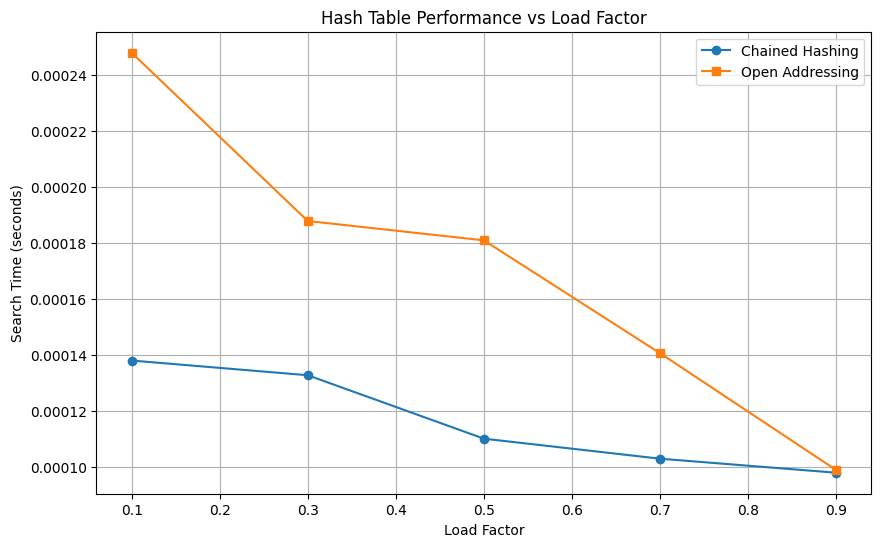

In [36]:
def plot_performance():
    """Визуализация производительности при разных коэффициентах загрузки"""
    load_factors = [0.1, 0.3, 0.5, 0.7, 0.9]
    search_times_chained = []
    search_times_open = []
    
    for lf in load_factors:
        size = 1000
        num_elements = int(size * lf)
        
        # Тестируем метод цепочек
        chained = ChainedHashTable(size)
        for i in range(num_elements):
            chained.insert(f"key_{i}", f"value_{i}")
        
        start = time.time()
        for i in range(100):
            chained.search(f"key_{i % num_elements}")
        search_times_chained.append(time.time() - start)
        
        # Тестируем открытую адресацию
        open_addr = OpenAddressingHashTable(size)
        for i in range(num_elements):
            open_addr.insert(f"key_{i}", f"value_{i}")
        
        start = time.time()
        for i in range(100):
            open_addr.search(f"key_{i % num_elements}")
        search_times_open.append(time.time() - start)
    
    plt.figure(figsize=(10, 6))
    plt.plot(load_factors, search_times_chained, 'o-', label='Chained Hashing')
    plt.plot(load_factors, search_times_open, 's-', label='Open Addressing')
    plt.xlabel('Load Factor')
    plt.ylabel('Search Time (seconds)')
    plt.title('Hash Table Performance vs Load Factor')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_performance()

In [ ]:
#indices = [None, None, 1, None, 0, None]
# entries = [
#     (key1, value1),
#     (key2, value2)
# ]

In [ ]:
import sys
import math

class PythonStyleDict:
    """
    Упрощенная реализация, демонстрирующая принципы работы Python dict
    """
    
    def __init__(self):
        # Начальный размер - степень двойки
        self.size = 8
        # Массив индексов (разреженный)
        self.indices = [None] * self.size
        # Плотный массив записей
        self.entries = []
        # Количество занятых ячеек
        self.used = 0
        # Маска для быстрого вычисления индекса
        self.mask = self.size - 1
    
    def _hash(self, key):
        """Хэш-функция + маскирование"""
        return hash(key) & self.mask
    
    def _probe(self, hash_value, i):
        """
        Псевдослучайное пробирование как в CPython.
        Это не линейное пробирование!
        """
        # В реальном Python используется более сложная формула:
        # i * 5 + 1 + perturb
        # где perturb изначально равно hash, затем perturb >>= 5
        return (hash_value + i) % self.size
    
    def _lookup(self, key, hash_value):
        """
        Алгоритм поиска, аналогичный CPython.
        Возвращает (index_in_indices, index_in_entries) или (-1, -1) если не найден
        """
        # Первичный индекс
        index = hash_value
        i = 0
        
        while True:
            if self.indices[index] is None:
                # Свободная ячейка - ключ не найден
                return index, -1
            
            # Получаем индекс в entries
            entries_index = self.indices[index]
            entry = self.entries[entries_index]
            
            if entry[0] == hash_value and entry[1] == key:
                # Нашли ключ
                return index, entries_index
            
            # Коллизия - продолжаем пробирование
            i += 1
            index = self._probe(hash_value, i)
            
            # Защита от бесконечного цикла
            if i > self.size:
                raise Exception("Hash table appears full")
    
    def _resize(self):
        """Изменение размера таблицы при высокой загрузке"""
        # В Python используется коэффициент загрузки ~2/3
        if self.used / self.size > 0.66:
            # Увеличиваем размер в 2 раза
            old_indices = self.indices
            old_entries = self.entries
            
            self.size *= 2
            self.mask = self.size - 1
            self.indices = [None] * self.size
            self.entries = []
            self.used = 0
            
            # Перехэширование всех элементов
            for entry in old_entries:
                self._insert_entry(entry[0], entry[1], entry[2])
    
    def _insert_entry(self, hash_value, key, value):
        """Вставка записи в таблицу"""
        index, existing_index = self._lookup(key, hash_value)
        
        if existing_index != -1:
            # Ключ уже существует - обновляем значение
            self.entries[existing_index] = (hash_value, key, value)
        else:
            # Новый ключ - добавляем
            self.entries.append((hash_value, key, value))
            self.indices[index] = len(self.entries) - 1
            self.used += 1
    
    def __setitem__(self, key, value):
        hash_value = self._hash(key)
        self._insert_entry(hash_value, key, value)
        self._resize()
    
    def __getitem__(self, key):
        hash_value = self._hash(key)
        index, entries_index = self._lookup(key, hash_value)
        
        if entries_index != -1:
            return self.entries[entries_index][2]
        else:
            raise KeyError(key)
    
    def __contains__(self, key):
        hash_value = self._hash(key)
        _, entries_index = self._lookup(key, hash_value)
        return entries_index != -1
    
    def get_stats(self):
        """Статистика словаря"""
        return {
            'size': self.size,
            'used': self.used,
            'entries_count': len(self.entries),
            'load_factor': self.used / self.size,
            'memory_indices': sys.getsizeof(self.indices),
            'memory_entries': sys.getsizeof(self.entries),
        }